In [57]:
# EDA and Data Cleaning 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Load the messy data
sales_df = pd.read_csv(r'data/sales_transactions.csv')
inventory_df = pd.read_csv(r'data/inventory_levels.csv')
external_df = pd.read_csv(r'data/external_factors.csv')
stores_df = pd.read_csv(r'data/stores.csv')
products_df = pd.read_csv(r'data/products.csv')

print(f"Sales: {sales_df.shape[0]:,} rows")
print(f"Inventory: {inventory_df.shape[0]:,} rows")
print(f"External: {external_df.shape[0]:,} rows")

Sales: 40,470 rows
Inventory: 8,343 rows
External: 3,655 rows


In [58]:
#QUICK EDA - FIND THE PROBLEMS

def quick_data_quality_check(df, name):
    """Quick data quality overview"""
    print(f"\n=== {name.upper()} DATA QUALITY ===")
    print(f"Shape: {df.shape}")
    print(f"Missing values: {df.isnull().sum().sum()}")
    print(f"Duplicates: {df.duplicated().sum()}")
    
    # Check for obvious issues
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        negative_counts = (df[numeric_cols] < 0).sum()
    print(f"Negative values: {negative_counts.sum()}")
    
    print("Missing by column:")
    missing = df.isnull().sum()
    print(missing[missing > 0])

# Check all datasets
quick_data_quality_check(sales_df, "Sales")
quick_data_quality_check(inventory_df, "Inventory") 
quick_data_quality_check(external_df, "External")


=== SALES DATA QUALITY ===
Shape: (40470, 7)
Missing values: 5993
Duplicates: 0
Negative values: 185
Missing by column:
unit_price       2980
total_revenue    3013
dtype: int64

=== INVENTORY DATA QUALITY ===
Shape: (8343, 8)
Missing values: 820
Duplicates: 0
Negative values: 443
Missing by column:
current_stock    820
dtype: int64

=== EXTERNAL DATA QUALITY ===
Shape: (3655, 10)
Missing values: 325
Duplicates: 0
Negative values: 5
Missing by column:
temperature    325
dtype: int64


# SALES DATA CLEANING

In [59]:
sales_df.head()

,transaction_id,store_id,product_id,date,sales_quantity,unit_price,total_revenue
0,TXN72449,ST001,P001,2022-01-01,4,180.76,723.04
1,TXN25921,ST001,P003,2022-01-01,16,340.00,5440.00
2,TXN12345,ST001,P004,2022-01-01,14,239.67,3355.38
3,TXN61515,ST001,P006,2022-01-01,9,309.04,2781.36
4,TXN98706,ST001,P009,2022-01-01,12,131.46,1577.52


In [60]:
print("\n", sales_df.info())
print("\n", sales_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40470 entries, 0 to 40469
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  40470 non-null  object 
 1   store_id        40470 non-null  object 
 2   product_id      40470 non-null  object 
 3   date            40470 non-null  object 
 4   sales_quantity  40470 non-null  int64  
 5   unit_price      37490 non-null  float64
 6   total_revenue   37457 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 2.2+ MB

 None

        sales_quantity    unit_price  total_revenue
count    40470.000000  37490.000000   37457.000000
mean        10.873709    199.505529    1139.372329
std         56.387181     88.343173    1194.085901
min        -42.000000     32.750000      32.750000
25%          2.000000    156.280000     312.560000
50%          4.000000    189.760000     748.680000
75%          8.000000    277.950000    1545.200000
max     

In [61]:
sales_df['date'] = pd.to_datetime(sales_df['date'], errors = "coerce")

In [62]:
#As we already know that there are negative values in sales data which logically doesnt make any sense in sales
#There cannot be a negative sales. Hence we are going to delete such values

print("The shape of the data before removing invalid value is ", len(sales_df))

The shape of the data before removing invalid value is  40470


In [63]:
sales_df= sales_df[sales_df["sales_quantity"] >=0]

In [64]:
#Removing outliers

#From the describe built in we can observe that there are outliers which must be handles accordingly.

#And also, after exploring th outliers, i decided to keep the threshold for outlier removal as 99 percentile
q99 = sales_df["sales_quantity"].quantile(0.99)
sales_df = sales_df[sales_df["sales_quantity"] <=q99]

In [65]:
#Removing wrong store ID's
valid_stores = stores_df['store_id'].tolist()
sales_df= sales_df[sales_df['store_id'].isin(valid_stores)]

In [66]:
#Just to have consistency in the product id column, lets convert it to uppercase
sales_df['product_id'] = sales_df['product_id'].str.upper()

In [67]:
# Handle missing prices
sales_df = sales_df.merge(products_df[['product_id', 'unit_price']], 
                         on='product_id', how='left', suffixes=('', '_default'))

In [68]:
# Fill missing unit_price with default
sales_df['unit_price'] = sales_df['unit_price'].fillna(sales_df['unit_price_default'])


In [69]:
sales_df = sales_df.drop('unit_price_default', axis=1)

In [70]:
#For revenue column we can just re calculate where the missing cells exist
sales_df['total_revenue'] = sales_df['total_revenue'].fillna(
    sales_df['sales_quantity'] * sales_df['unit_price']
)

In [71]:
# Remove duplicates
sales_df = sales_df.drop_duplicates(subset=['transaction_id'])

In [72]:
print(f"After cleaning: {len(sales_df)} rows")

After cleaning: 31696 rows


In [75]:
print(f"Removed: {len(pd.read_csv('data/sales_transactions.csv')) - len(sales_df)} bad records")


Removed: 8774 bad records


# INVENTORY DATA CLEANING  


In [76]:
inventory_df.head()

,store_id,product_id,snapshot_date,current_stock,reorder_point,max_stock_level,supplier_lead_time,last_reorder_date
0,ST001,P002,2022-01-02,NaN,100,403,7,2021-12-29
1,ST001,P015,2022-01-02,221.0,237,951,3,2021-12-04
2,ST001,P016,2022-01-02,25.0,31,125,5,2021-12-17
3,ST001,P018,2022-01-02,15.0,88,353,14,2021-12-06
4,ST001,P019,2022-01-02,200.0,193,775,3,2022-01-01


In [79]:
inventory_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8343 entries, 0 to 8342
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   store_id            8343 non-null   object 
 1   product_id          8343 non-null   object 
 2   snapshot_date       8343 non-null   object 
 3   current_stock       7523 non-null   float64
 4   reorder_point       8343 non-null   int64  
 5   max_stock_level     8343 non-null   int64  
 6   supplier_lead_time  8343 non-null   int64  
 7   last_reorder_date   8343 non-null   object 
dtypes: float64(1), int64(3), object(4)
memory usage: 521.6+ KB


In [83]:
inventory_df.describe()

,current_stock,reorder_point,max_stock_level,supplier_lead_time
count,7523.000000,8343.000000,8343.000000,8343.000000
mean,204.726306,146.341843,622.131008,6.018578
std,173.573330,88.364997,329.845193,4.466747
min,0.000000,-10.000000,60.000000,1.000000
25%,63.000000,71.000000,338.000000,3.000000
50%,154.000000,147.000000,619.000000,5.000000
75%,308.000000,222.000000,911.000000,7.000000
max,792.000000,299.000000,1199.000000,14.000000


In [86]:
inventory_df['snapshot_date'] = pd.to_datetime(inventory_df['snapshot_date'])
inventory_df['last_reorder_date'] = pd.to_datetime(inventory_df['last_reorder_date'])


In [87]:
# Fix negative reorder points
inventory_df.loc[inventory_df['reorder_point'] < 0, 'reorder_point'] = 0

In [88]:
# Fill missing current_stock with 0 (assume empty)
inventory_df['current_stock'] = inventory_df['current_stock'].fillna(0)

In [89]:
# Remove impossible values
inventory_df = inventory_df[inventory_df['supplier_lead_time'] <= 30]

In [90]:
print(f"Inventory cleaned: {len(inventory_df)} records")

Inventory cleaned: 8343 records


# EXTERNAL DATA CLEANING

In [91]:
external_df

,date,city,temperature,precipitation,is_weekend,day_of_week,month,quarter,competitor_promotion,local_event
0,2022-01-01,Boston,41.8,0.04,True,Saturday,1,1,False,False
1,2022-01-01,Austin,86.4,0.04,True,Saturday,1,1,False,False
2,2022-01-01,Seattle,56.5,0.11,True,Saturday,1,1,False,False
3,2022-01-01,Denver,31.7,0.11,True,Saturday,1,1,False,False
4,2022-01-01,Chicago,69.8,0.01,True,Saturday,1,1,False,False
...,...,...,...,...,...,...,...,...,...,...
3650,2024-01-01,Boston,54.2,0.07,False,Monday,1,1,True,False
3651,2024-01-01,Austin,86.2,0.02,False,Monday,1,1,True,False
3652,2024-01-01,Seattle,50.8,0.06,False,Monday,1,1,False,False
3653,2024-01-01,Denver,83.9,0.05,False,Monday,1,1,False,False


In [92]:
external_df.describe()

,temperature,precipitation,month,quarter
count,3330.000000,3655.000000,3655.000000,3655.000000
mean,65.246667,0.096733,6.518468,2.507524
std,20.256545,0.096323,3.452013,1.117550
min,-12.700000,0.000000,1.000000,1.000000
25%,51.900000,0.030000,4.000000,2.000000
50%,65.250000,0.070000,7.000000,3.000000
75%,78.600000,0.130000,10.000000,4.000000
max,131.900000,0.860000,12.000000,4.000000


In [93]:
external_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3655 entries, 0 to 3654
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  3655 non-null   object 
 1   city                  3655 non-null   object 
 2   temperature           3330 non-null   float64
 3   precipitation         3655 non-null   float64
 4   is_weekend            3655 non-null   bool   
 5   day_of_week           3655 non-null   object 
 6   month                 3655 non-null   int64  
 7   quarter               3655 non-null   int64  
 8   competitor_promotion  3655 non-null   bool   
 9   local_event           3655 non-null   bool   
dtypes: bool(3), float64(2), int64(2), object(3)
memory usage: 210.7+ KB


In [95]:
#Fixing date column datetype
external_df['date'] = pd.to_datetime(external_df['date'])

In [96]:
# Fix temperature (remove impossible values)
external_df = external_df[(external_df['temperature'] >= -20) & 
                         (external_df['temperature'] <= 120)]

In [97]:
# Fill missing temperature with city average
temp_avg = external_df.groupby('city')['temperature'].mean()
for city in external_df['city'].unique():
    mask = (external_df['city'] == city) & (external_df['temperature'].isnull())
    external_df.loc[mask, 'temperature'] = temp_avg[city]

In [98]:
# Standardize day_of_week format
external_df['day_of_week'] = external_df['day_of_week'].str.title()
day_mapping = {'Mon': 'Monday', 'Tue': 'Tuesday', 'Wed': 'Wednesday', 
               'Thu': 'Thursday', 'Fri': 'Friday', 'Sat': 'Saturday', 'Sun': 'Sunday'}
external_df['day_of_week'] = external_df['day_of_week'].replace(day_mapping)

In [100]:
print(f"External data cleaned: {len(external_df)} records")

External data cleaned: 3320 records


# KEY BUSINESS INSIGHTS FROM CLEAN DATA

## Daily sales trend

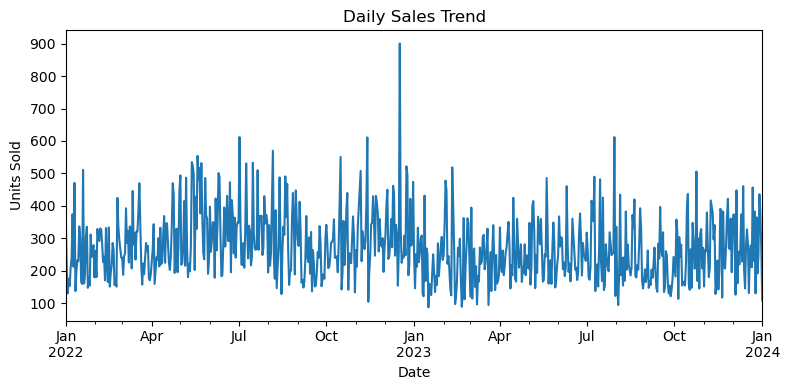

In [139]:
import matplotlib.pyplot as plt

# Group by date and sum sales
daily_sales = sales_df.groupby('date')['sales_quantity'].sum()

# Plot
plt.figure(figsize=(8, 4))
daily_sales.plot()
plt.title('Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.tight_layout()
plt.show()


## Sales by store type

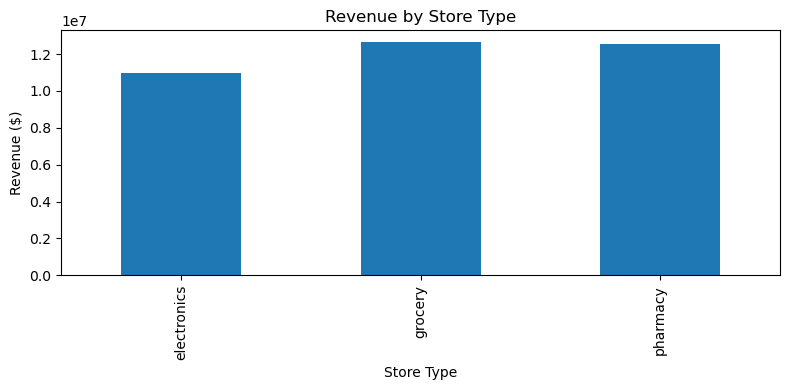

In [145]:
# Merge sales with store info
store_sales = sales_df.merge(stores_df, on='store_id')

# Group by store type and sum revenue
store_type_sales = store_sales.groupby('type')['total_revenue'].sum()

# Plot
plt.figure(figsize=(8, 4))
store_type_sales.plot(kind='bar')
plt.title('Revenue by Store Type')
plt.ylabel('Revenue ($)')
plt.xlabel('Store Type')
plt.tight_layout()
plt.show()


## Top products by revenue

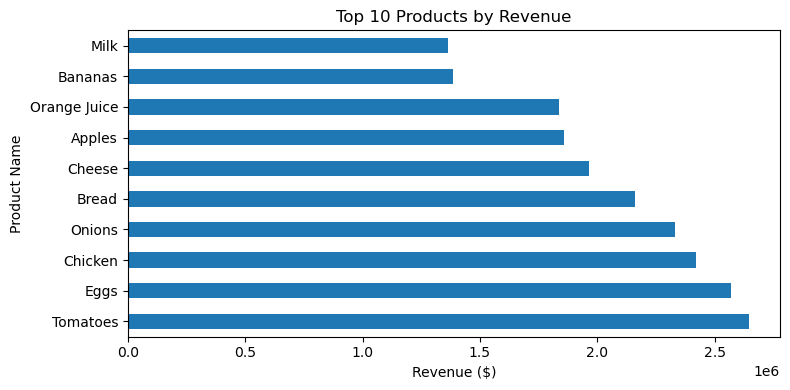

In [125]:
# Merge sales with product info
product_revenue = sales_df.merge(products_df, on='product_id')

# Group by product name and get top 10 by revenue
top_products = product_revenue.groupby('name')['total_revenue'].sum().nlargest(10)

# Plot
plt.figure(figsize=(8, 4))
top_products.plot(kind='barh')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Revenue ($)')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()


## Seasonal patterns

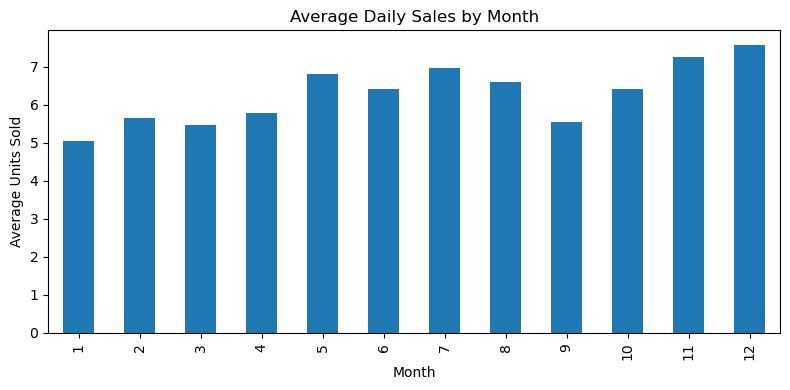

In [128]:
# Extract month from date
sales_df['month'] = sales_df['date'].dt.month

# Group by month and calculate average daily sales
monthly_sales = sales_df.groupby('month')['sales_quantity'].mean()

# Plot
plt.figure(figsize=(8, 4))
monthly_sales.plot(kind='bar')
plt.title('Average Daily Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Units Sold')
plt.tight_layout()
plt.show()


## Weekday patterns 

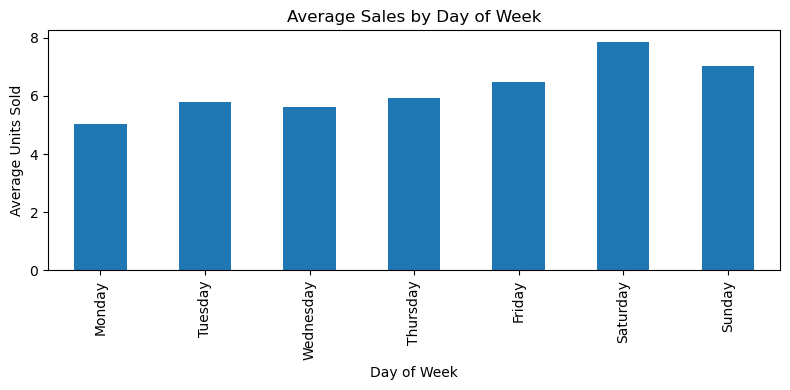

In [132]:
# Extract day name from date
sales_df['day_of_week'] = sales_df['date'].dt.day_name()

# Group by day of week and calculate average sales
weekday_sales = sales_df.groupby('day_of_week')['sales_quantity'].mean()

# Ensure correct weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sales = weekday_sales.reindex(weekday_order)

# Plot
plt.figure(figsize=(8, 4))
weekday_sales.plot(kind='bar')
plt.title('Average Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Units Sold')
plt.tight_layout()
plt.show()


## Stock level distribution

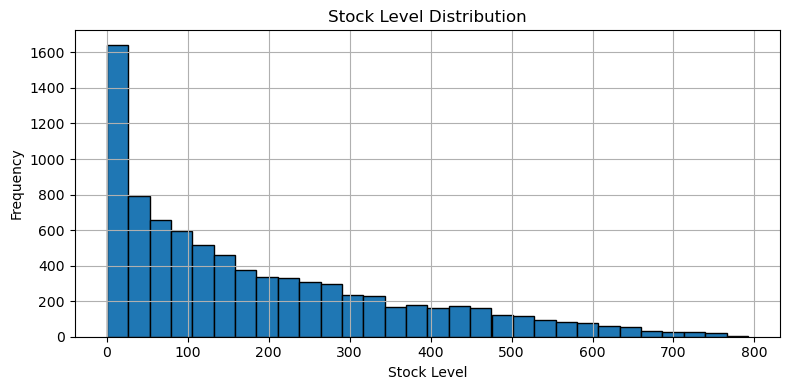

In [141]:
# Plot histogram of current stock levels
plt.figure(figsize=(8, 4))
inventory_df['current_stock'].hist(bins=30, edgecolor='black')
plt.title('Stock Level Distribution')
plt.xlabel('Stock Level')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [149]:
# Print key insights
print("\nKEY FINDINGS:")
print(f"• Peak sales month: {monthly_sales.idxmax()} (avg {monthly_sales.max():.1f} units/day)")
print(f"• Best sales day: {weekday_sales.idxmax()} (avg {weekday_sales.max():.1f} units)")
print(f"• Top store type: {store_type_sales.idxmax()} (${store_type_sales.max():,.0f} revenue)")
print(f"• Average stock level: {inventory_df['current_stock'].mean():.1f} units")


KEY FINDINGS:
• Peak sales month: 12 (avg 7.6 units/day)
• Best sales day: Saturday (avg 7.9 units)
• Top store type: grocery ($12,656,005 revenue)
• Average stock level: 184.6 units


# Saving the clean data to another csv

In [152]:
# Add useful features to sales data
sales_df['year'] = sales_df['date'].dt.year
sales_df['month'] = sales_df['date'].dt.month
sales_df['day_of_week'] = sales_df['date'].dt.day_name()
sales_df['is_weekend'] = sales_df['date'].dt.weekday >= 5

# Merge with store and product info
sales_clean = sales_df.merge(stores_df, on='store_id')
sales_clean = sales_clean.merge(products_df[['product_id', 'category', 'unit_cost']], on='product_id')

# Save clean datasets
sales_clean.to_csv('sales_clean.csv', index=False)
inventory_df.to_csv('inventory_clean.csv', index=False)
external_df.to_csv('external_clean.csv', index=False)